## EDS 220: Data Wrangling with Rasters and False Color Imagery
###### Author: Henry Oliver
###### Github Repository: https://github.com/ht-oliver/eds220-hwk4

##### **Purpose**
 The purpose of this walkthrough to utilize false color satellite imagery to investigate the extent of wildfires in California in January, 2025. This anlaysis will walk through the steps necessary to display Landsay 8 satellite imagery overlayed with estimated perimeters of the 2025 LA County Palisades and Eaton Fires.

##### **Background**
The Palisades and Eaton fires burned across parts of Los Angeles County, leaving visible scars on the landscape. Using Landsat satellite imagery, we can highlight burn areas, compare pre- and post-fire conditions, and better understand the extent and distribution of damage. Remote sensing provides an objective, large-scale view that complements on-the-ground assessments and helps support recovery planning and ecological monitoring.

##### **Highlights**
  - Wrangling and displaying `.shp ` and `.nc` file types
  - Producing True and False color imagery
  - Creating useful, intuitive, and accurate visualizations

### **Part 1: Installing libraries**
Performing the data download, manipulation, and displays in this analysis requires the installation of several publicly-available software packages.

In [1]:
import os                           # file and path handling
import pandas as pd                 # tabular data analysis
import matplotlib.pyplot as plt     # plotting and visualization
import xarray as xr                 # working with labeled multi-dimensional data (e.g., rasters)
import rioxarray as rio             # geospatial raster I/O and spatial operations
import netCDF4                      # reading NetCDF datasets
import geopandas as gpd             # vector geospatial data (shapefiles, geodataframes)
import numpy as np                  # numerical operations and arrays


### **Part 2: Fire Perimeter data**
Shapefiles for the outline of LA County fires are provided by LA County. This step contains a method to download, join, project, and display fire perimeter data. Make sure to carefully read comments for reasoning behind each code chunk.

Below are the data sources for each perimeter shapefile.

##### Eaton Fire
 - **File Name**: Eaton_Perimeter_20250121.shp
 - **Source**: https://egis-lacounty.hub.arcgis.com/datasets/
lacounty::palisades-and-eaton-dissolved-fire-perimeters-2025/explore?layer=0
 - **Publisher**: County of Los Angeles
 - **Date**: February 26, 2025

##### Palisades Fire
 - **File Name**: Palisades_Perimeter_20250121.shp
 - **Source**: https://egis-lacounty.hub.arcgis.com/datasets/lacounty::palisades-and-eaton-dissolved-fire-perimeters-2025/explore?layer=1&location=34.133066%2C-118.349606%2C9.60
 - **Publisher**: County of Los Angeles
 - **Date**: February 26, 2025

In [2]:
# Download Eaton shapefile
eaton = gpd.read_file(os.path.join('data',
                                   'Eaton_Perimeter_20250121',
                                   'Eaton_Perimeter_20250121.shp'))

# Download Palisades shapefile
palisades = gpd.read_file(os.path.join('data',
                                   'Palisades_Perimeter_20250121',
                                   'Palisades_Perimeter_20250121.shp'))


### **Part 2) Fire Perimeter Data Exploration**
Let's get a bit more familiar with our fire perimeter data. Eventually, we will want to join these two files into a single layer and plot them in combination with raster data for our final visualization. In order to do so we must first confirm that our shapefiles have the data we want to visualize, and are compatible with eachother.

First, let's check what our data frame looks like using the `head()` method, and check the data type of our Eaton shapefile using the `type()` function.

In [3]:
# Check data type of `eaton`
print(f"Eaton shapefile data type is: {type(eaton)}")
# Visualize data frame
eaton.head()

Eaton shapefile data type is: <class 'geopandas.geodataframe.GeoDataFrame'>


OBJECTID            type    Shape__Are  Shape__Len  \
0         1  Heat Perimeter   2206.265625  270.199719   
1         2  Heat Perimeter  20710.207031  839.204218   
2         3  Heat Perimeter   3639.238281  250.304502   
3         4  Heat Perimeter   1464.550781  148.106792   
4         5  Heat Perimeter   4132.753906  247.960744   

                                            geometry  
0  POLYGON ((-13146936.686 4051222.067, -13146932...  
1  POLYGON ((-13150835.463 4052713.929, -13150831...  
2  POLYGON ((-13153094.697 4053057.596, -13153113...  
3  POLYGON ((-13145097.740 4053118.235, -13145100...  
4  POLYGON ((-13153131.126 4053196.882, -13153131...

Now let's do the same thing for our Palisade shapefile

In [4]:
# Check data type of `palisades`
print(f"Palisade shapefile data type is: {type(palisades)}")
# Visualize data frame
palisades.head()

Palisade shapefile data type is: <class 'geopandas.geodataframe.GeoDataFrame'>


OBJECTID            type    Shape__Are   Shape__Len  \
0         1  Heat Perimeter   1182.082031   267.101144   
1         2  Heat Perimeter   2222.488281   185.498783   
2         3  Heat Perimeter     21.011719    22.412814   
3         4  Heat Perimeter    214.992188    76.639180   
4         5  Heat Perimeter  44203.453125  1569.259764   

                                            geometry  
0  POLYGON ((-13193543.302 4032913.077, -13193543...  
1  POLYGON ((-13193524.155 4033067.953, -13193524...  
2  POLYGON ((-13193598.085 4033158.222, -13193598...  
3  POLYGON ((-13193654.249 4033146.033, -13193656...  
4  POLYGON ((-13194209.580 4033236.320, -13194209...

#### What did we learn?
The `type()` method showed us that both `palisades` and `eaton` are classified as `geopandas.geodatafame.GeoDataFrame`. This tells us that {WHAT IS A GEODATAFRAME}

The `head()` method shows us the first 5 rows in our geodataframe. This shows us that our shapefile is comprised of multiple polygons.

#### CRS and Projection
Next, we want to confirm that we'll be able to use these shapefiles in the same plot. In order to do so, our Geodataframes must share a Coordinate Reference System (CRS). A CRS defines how spatial data like shapefiles and rasters are projected onto the Earth’s surface, ensuring that their locations align correctly when plotted with GIS systems. We will check our CRS with the `.crs` attribute. Then we'll check if the CRS is projected or geographic. A projected CRS flattens the curved surface of the Earth onto a 2D map using a specific mathematical projection, while a geographic CRS describes locations directly with latitude and longitude on a spherical or ellipsoidal Earth.

In [5]:
# Check CRS
print(f"Eaton CRS is: {eaton.crs}")
print(f"Palisades CRS is: {palisades.crs}")
assert eaton.crs == palisades.crs # Returns error if CRS don't match

# Check if projected
print(f"Eaton CRS is projected. {eaton.crs.is_projected}")
print(f"Palisades CRS is projected. {palisades.crs.is_projected}")
assert (eaton.crs.is_projected and palisades.crs.is_projected) == True # Returns error if not projected

Eaton CRS is: EPSG:3857
Palisades CRS is: EPSG:3857
Eaton CRS is projected. True
Palisades CRS is projected. True


Now lets take a look at our plots, separately, using the `.plot()` method

<Axes: >

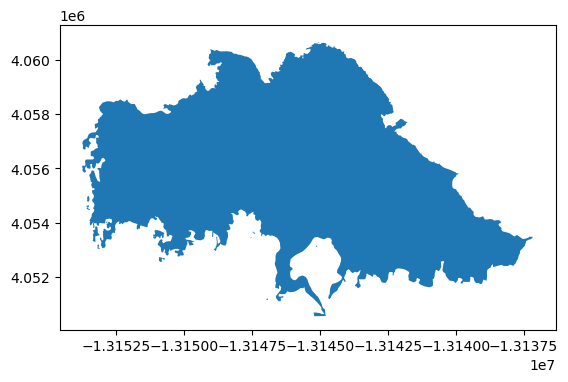

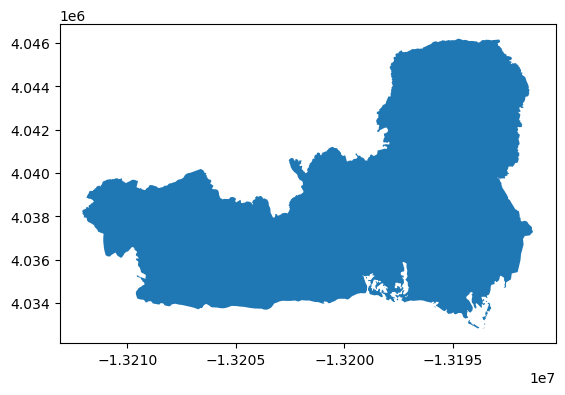

In [6]:
# Preliminary plots
eaton.plot()
palisades.plot()

**#### What did we learn?**
Our CRS is EPSG:3857 and is projected, which means is better suited for measurements and plotting on a 2D map.

Now that we know our CRSs match, we can combine our fires into a single file.

<Axes: >

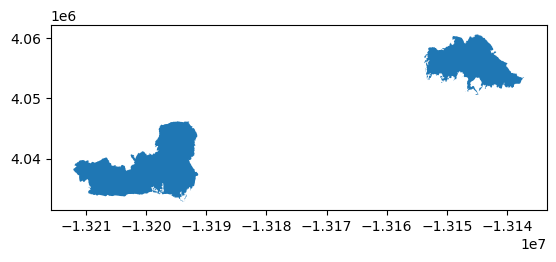

In [7]:
# Combine eaton and palisades shapefiles
fires = gpd.GeoDataFrame(pd.concat([eaton, palisades]))

# Confirm successful combination by plotting
fires.plot()

### **Part 3: NetCDF data import and exploration**
Next, we want to plot these perimeters on top of a raster showing false-color imagery. In order to do that, we'll need to make some slight modifications to our landsat data. Our Landsat 8 data is in NetCDF format (.nc), as opposed to our fire perimeters which were shapefiles (.shp). We'll have to take specific steps to read it in correctly and specify our CRS.

Below is the data source for Landsat 8 imagery
##### **Landsat 8 Imagery of LA County**
 - **File Name**: 'landsat8-2025-02-23-palisades-eaton.nc'
 - **Source**: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
 - **Publisher**: Microsoft Planetary Computer
 - **Date**: February 26, 2025


 To read in our data we will first create filepath, then use a tool from the `xarray` package, `xr.open_dataset` to read it.

In [8]:
# Create filepath
path = ('data/landsat8-2025-02-23-palisades-eaton.nc')

# Read in landsat netCDF4 data package with xarray
landsat = xr.open_dataset(path)

Next, we'll find out what kind of data we're working with with the same `type()` method from before, and calling our data. Then we'll check if a CRS is assigned using the `.rio.crs` attribute.

In [9]:
# Print data type
print(f"landsat data type is: {type(landsat)}")

# Call data to view bands, dimensions & coordinates
landsat

# Once the data is displayed below, click the page icon on the x or y coordinate to view the CRS and resolution
# Now let's check if this CRS is assigned
# Print CRS of landsat data
print(landsat.rio.crs)

landsat data type is: <class 'xarray.core.dataset.Dataset'>
None


#### **What did we learn?**

We found our that our landsat data is a `xarray` dataset, which is a essentially a multi-dimensional set of arrays. By printing `landsat` we were able to access the number of bands, the dimensions, and the CRS for x and y coordinate. We're also able to tell that this data has 5 spectral bands including: red, green, nir08, and swir22.

**Click the page icon by the x coordinate on this list to view attributes for the coordinate system. This should tell us the CRS.**

 The CRS for the x and y coordinates is EPSG:32611, and it is projected.  Finally also able to see that the units of the CRS are meters, and the resolution is 30x30 meters. Unfortunately, our CRS is not assigned, we just know that our coordinates use EPSG:32611. Next, we'll need to assign a CRS to our `landsat` object.

### Part 4: Restoring geospatial information

Right now, our Landsat ratio does not have an assigned CRS, though it does have a reference CRS. We need to fix that so our data can be displayed with our fire perimeters. We'll assign our refernece CRS using the `.rio.write_crs()` method.

In [10]:
# Write CRS to WGS 84 / UTM zone 11N or 'EPSG:32611'
# inplace=True overwrites our landsat object to assign CRS
landsat.rio.write_crs(["EPSG", "32611"], inplace=True)

# Print to confirm it worked. This should return 'EPSG:32611'
print(landsat.rio.crs)

EPSG:32611


### Part 5: True color image

Our `landsat` data contains 6 raster layers with information. Eventually we want to view a 'False Color' Image of fire location, but first we'll take a look at the 'True Color' image. True Color images display the 'red', 'blue' and 'green' light as detected by the satellite, which is similar to the way the image would be interpreted by our eyes. In order to display this information, we'll have to specify which pieces of the data we want to plot, and how we want to plot it. This won't work on the first try, but following the instructions a-d below will help the process make sense. There will be a brief discussion after step d.

a) **Without creating any new variables:**
 - select the red, green and blue variables (in that order) of the `xarray.Dataset` holding the Landsat data,
 - convert it to a `numpy.array` using the `to_array()` method, and then
 - use `.plot.imshow()` to create an RGB image with the data. There will be two warnings, that's


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/henryoliver/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


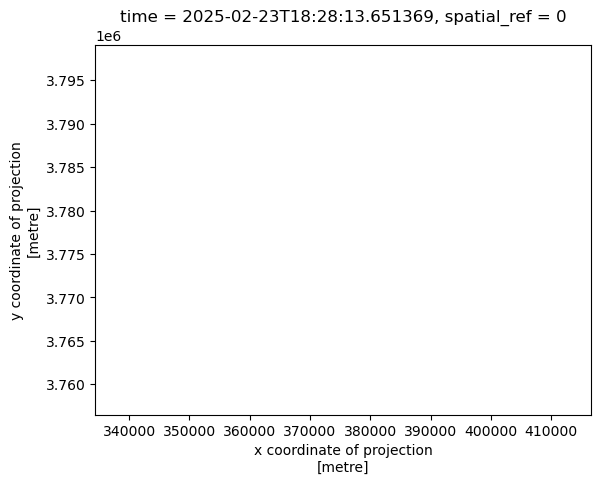

In [11]:
# Attempt to print true color image
landsat[['red', 'green', 'blue']].to_array().plot.imshow()


 **b) Adjust the scale used for plotting the bands to get a true color image. HINT: Check the robust parameter. The issue here is the clouds: their RGB values are outliers and cause the other values to be squished when plotting.**

/Users/henryoliver/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


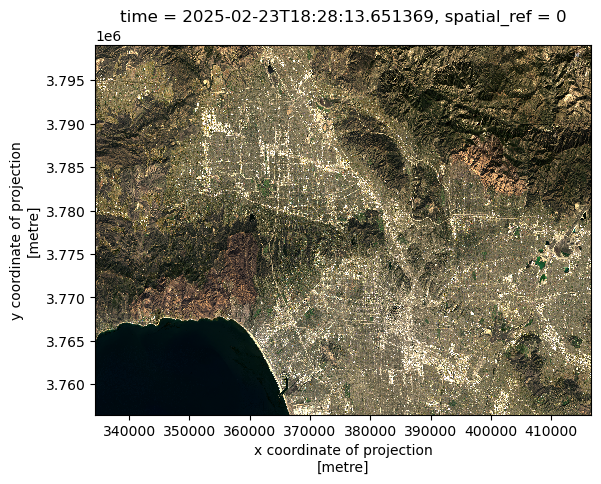

In [12]:
# Print true color image 
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

**c) To resolve the other warning, identify which bands have `nan` values. HINT: There are many ways of doing so. ne option is to use the `numpy.isnan()`.**

In [13]:
# Access bands with NA values
np.isnan(landsat)

<xarray.Dataset> Size: 19MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) bool 4MB False False False False ... False False False
    green        (y, x) bool 4MB False False False False ... False False False
    blue         (y, x) bool 4MB False False False False ... False False False
    nir08        (y, x) bool 4MB False False False False ... False False False
    swir22       (y, x) bool 4MB False False False False ... False False False

**d) use `.fillna()` method for `xarray.Dataset` to substitute the any `nan` values in the Landsat data for zero**

In [14]:
# Fill na landsat values with 0
landsat.fillna(0)

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 16MB 1.024e+04 9.886e+03 ... 1.019e+04 9.967e+03
    green        (y, x) float32 16MB 9.93e+03 9.687e+03 ... 9.984e+03 9.662e+03
    blue         (y, x) float32 16MB 9.29e+03 9.183e+03 ... 9.49e+03 9.187e+03
    nir08        (y, x) float32 16MB 1.331e+04 1.313e+04 ... 1.287e+04 1.306e+04
    swir22       (y, x) float32 16MB 1.43e+04 1.437e+04 ... 1.406e+04 1.329e+04

**e) Create a new true color image that gets plotted without warnings**

/Users/henryoliver/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


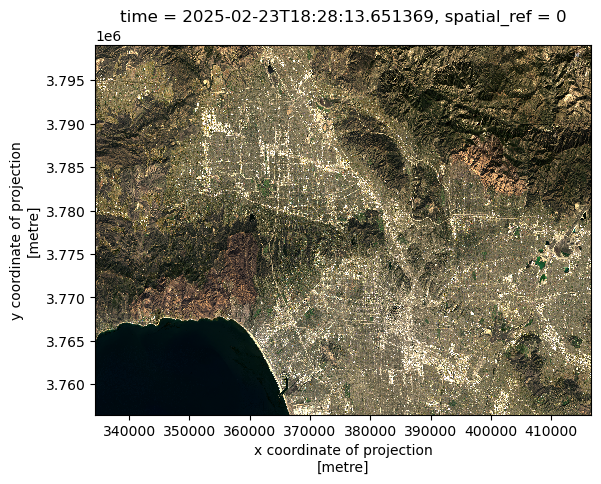

In [15]:
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

Why weren't we getting an image at the beginning? What changed to give us our True Color image?

The output in part a) showed a blank plot, which was not displaying any of the bands that we had selected. This is because once the minimum, maximum and NA data for each band were not specified, and as a result the bands could not be printed. Consequently, only the x & y data was plotted. In part e) our plot shows a realistic true color image without warnings. This is because by adding the `robust = True` argument to my `im.show()` method, the vmin and vmax values for each band are specified, which allows the bands to be displayed accurately. Also, by turning the NA values to 0, we can eliminate the warning about NA values, without comprimising our image.

### **Step 6: False color image**

'False color' images display short-wave infrared, near-infrared, and red light as detected by the satellite. While these images are less accurate to our visual interpretation of a landscape, they help highlight certain difficult-to-see characteristics of a landscape.

**a) Without creating any new variables, create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order)**

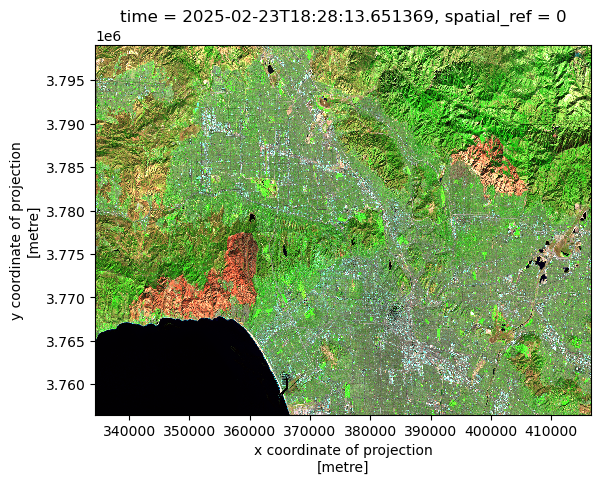

In [16]:
# Display false color image
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

### Step 7: Map
Now we can put it all together, and plot our fire perimeters shapefile on top of our false color imagery. In order to do so, we'll need to make sure that our imagery and perimeters share a CRS. We'll assign our `fires` dataset to our `landsat` CRS using the `to_crs()` function.

In [17]:
# Make sure our fires and imagery have the same CRS
fires = fires.to_crs(landsat.rio.crs)
assert(fires.crs == landsat.rio.crs)

#### **Plot!**

Now we can plot our data. We'll start by setting up our plot and axes, then we'll plot our data in layers. First, we'll plot our false color imagery using our method from above. Then we'll plot our fire perimeter. Finally, we'll add data labels, captions and image credits. There are lots of small specifications we'll need to make for our map to show up in a cisually pleasing a useful way. Read comments for more details on unfamiliar syntax.

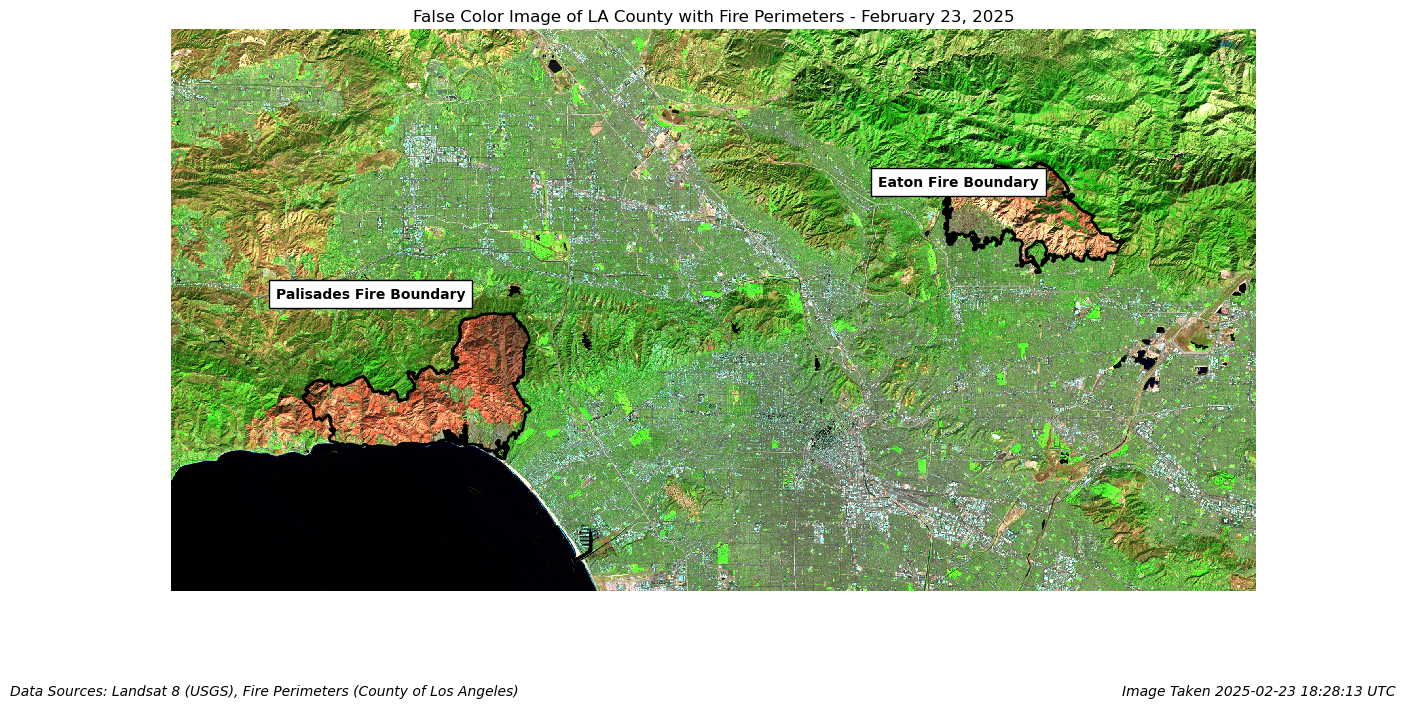

In [19]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot LANDSAT false color imagery
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow( # Select false color bands
    robust=True,
    ax=ax,
    add_colorbar = False,
    zorder = 0) # Specify this is the borrom layer of our plot
# Add title
ax.set_title("False Color Image of LA County with Fire Perimeters - February 23, 2025")

# Plot fire perimeters
fires.plot(
    ax=ax,
    edgecolor='black', # Specify border color of fire perimeters
    facecolor= "none", # Specify fill color of perimeters
    linewidth=2, # Specify border thicness
    alpha= 1,
    zorder=1 # Specify plot to be on TOP of satellite imagery
)
# Remove map axis
ax.axis('off')

# Add Map data labels
plt.figtext(x=.63, y=.65, s="Eaton Fire Boundary", weight='bold',
            bbox = {'facecolor': 'white', #Add text border
                    'pad':5})
plt.figtext(x=.2,  y=.51, s="Palisades Fire Boundary", weight='bold',
            bbox = {'facecolor': 'white', #Add text border
                    'pad':5})

# Add Data Citation
fig.text(
    0.01, 0.01, 
    "Data Sources: Landsat 8 (USGS), Fire Perimeters (County of Los Angeles)", 
    fontsize=10,
    ha='left', 
    va='bottom',
    style = 'italic'
)

# Add Timestamp
fig.text(
    1, 0.01, 
    "Image Taken 2025-02-23 18:28:13 UTC", 
    fontsize=10,
    ha='right', 
    va='bottom',
    style = 'italic'
)
plt.show()

#### Interpretation:

The figure shows false-color Landsat imagery of Los Angeles County, with the Palisades and Eaton fire perimeters outlined in black. In this image, blue and green light are substituted with reading for short-wave (SWIR) and near-infrared (NIR) light respectively. As a result, healthy vegetation appears in shades of green (healthy vegetation has relatively high reflectence of NIR), bare ground or urban areas appear in gray to brown, and the areas affected by fire stand out in red (low NIR reflections, high SWIR), highlighting burned vegetation. By overlaying the fire perimeters, we can clearly see how the fire boundaries correspond to the affected areas, providing a visual confirmation of the fire extent.

#### References:

County of Los Angeles. (2025). Eaton fire perimeter (Version 2025-02-21) [Shapefile]. Los Angeles County GIS Hub. https://egis-lacounty.hub.arcgis.com/datasets/lacounty::palisades-and-eaton-dissolved-fire-perimeters-2025/explore?layer=0

County of Los Angeles. (2025). Palisades fire perimeter (Version 2025-02-21) [Shapefile]. Los Angeles County GIS Hub. https://egis-lacounty.hub.arcgis.com/datasets/lacounty::palisades-and-eaton-dissolved-fire-perimeters-2025/explore?layer=1&location=34.133066%2C-118.349606%2C9.60

Microsoft Planetary Computer. (2025). Landsat 8 imagery of Los Angeles County (February 23, 2025) [NetCDF]. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2